In [39]:
from pharynx_analysis import (pharynx_io as pio, image_processing as ip, experiment, plots)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import xarray as xr
from importlib import reload
from skimage import measure, transform
from collections import namedtuple
import pdb
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import scale
import pandas as pd
from scipy.signal import find_peaks
from pprint import pprint
from pathlib import Path
from skimage import io as skio

reload(pio);
reload(ip);
reload(experiment);

dir_path = Path("/Users/sean/code/wormAnalysis/data/paired_ratio_minimal/2017_02_22-HD233_SAY47-OK/")
imaging_scheme = "TL/470/410/470/410"


img_path = str(dir_path.joinpath(dir_path.stem + '.tif'))
strain_map_path = str(dir_path.joinpath('indexer.csv'))

strains = pio.load_strain_map_from_disk(strain_map_path)

In [4]:
ex = experiment.PairExperiment(img_path, imaging_scheme, strains)

../pharynx_analysis/image_processing.py:322: RuntimeWarning: invalid value encountered in greater
  first = np.argmax(profile > threshold)
../pharynx_analysis/image_processing.py:323: RuntimeWarning: invalid value encountered in greater
  last = len(profile) - np.argmax(np.flip(profile > threshold))
../pharynx_analysis/image_processing.py:322: RuntimeWarning: invalid value encountered in greater
  first = np.argmax(profile > threshold)
../pharynx_analysis/image_processing.py:323: RuntimeWarning: invalid value encountered in greater
  last = len(profile) - np.argmax(np.flip(profile > threshold))
/Users/sean/.local/share/virtualenvs/python-zUhjj0fC/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [5]:
mids = ex.midlines
i410 = ex.raw_image_data.sel(wavelength='410', pair=0)

In [13]:
i410[0].shape

(130, 174)

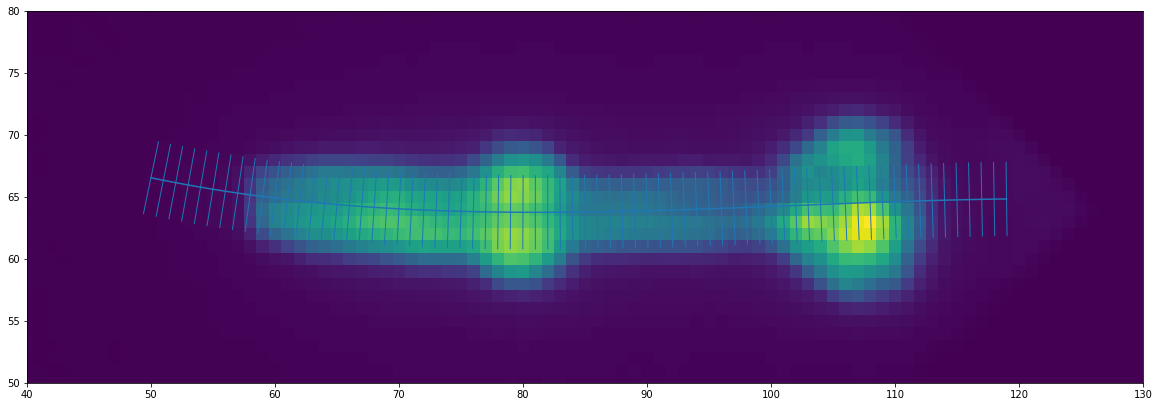

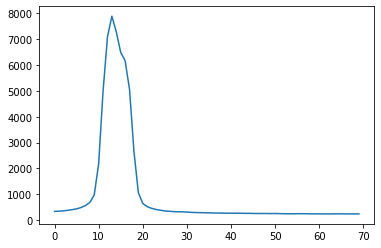

In [144]:
i = 0
I = ex.rot_fl.sel(wavelength='410', pair=0).isel(strain=i)
mid = mids[i]['410'][0]
der = mid.derivative()

xs = np.arange(50, 120)
ys = mid(xs)

normal_slopes = -1/der(xs)
normal_thetas = np.arctan(normal_slopes)

mag = 3
x0 = np.cos(normal_thetas) * mag
y0 = np.sin(normal_thetas) * mag

x1 = np.cos(normal_thetas) * -mag
y1 = np.sin(normal_thetas) * -mag

xs0 = xs + x0
xs1 = xs + x1
ys0 = ys + y0
ys1 = ys + y1

lines = [list(x) for x in zip(zip(xs0, ys0), zip(xs1, ys1))]
lc = LineCollection(lines, linewidths=1)
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(I)
ax.plot(xs, ys)
ax.add_collection(lc)
ax.set_aspect('equal')
ax.set_xlim(40,130)
ax.set_ylim(50,80)

prof = [
    np.mean(
        measure.profile_line(
            I,
            (xs0[i], ys0[i]), (xs1[i], ys1[i]), order=0, linewidth=1
        )
    )
    for i in range(len(xs0))
]
plt.figure()
plt.plot(prof);

In [146]:
measure.profile_line(I, (50, 60), (120, 60))

array([ 306.,  302.,  327.,  344.,  344.,  357.,  384.,  410.,  452.,
        532.,  854., 1976., 4419., 5902., 5967., 4918., 4672., 3499.,
       1697.,  666.,  510.,  445.,  402.,  362.,  342.,  330.,  322.,
        315.,  303.,  300.,  286.,  283.,  279.,  267.,  273.,  276.,
        277.,  289.,  276.,  270.,  273.,  264.,  258.,  251.,  253.,
        251.,  249.,  260.,  261.,  246.,  242.,  246.,  251.,  247.,
        244.,  245.,  247.,  240.,  239.,  245.,  245.,  238.,  232.,
        234.,  229.,  236.,  249.,  237.,  235.,  231.,  229.])

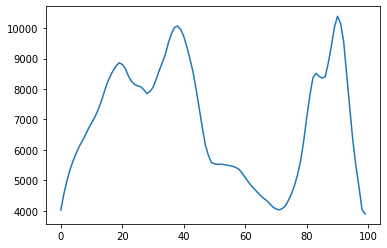

In [140]:
plt.plot(ex.trimmed_intensity_data.sel(wavelength='410', pair=0).isel(strain=0))

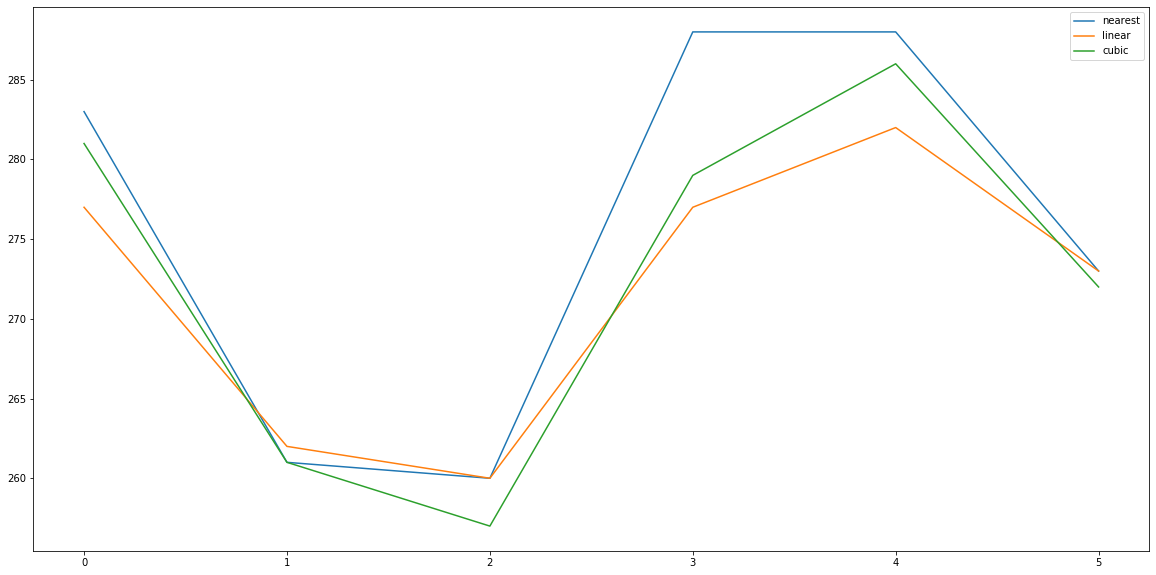

In [47]:
fig = plt.figure(figsize=(20,10))
i = 50
plt.plot(measure.profile_line(i410[0], (xs0[i], ys0[i]), (xs1[i], ys1[i]), order=0), label='nearest')
plt.plot(measure.profile_line(i410[0], (xs0[i], ys0[i]), (xs1[i], ys1[i]), order=1), label='linear')
plt.plot(measure.profile_line(i410[0], (xs0[i], ys0[i]), (xs1[i], ys1[i]), order=2), label='cubic')
plt.legend()

# Compare line thickness errors

In [440]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [441]:
from scipy.stats import norm

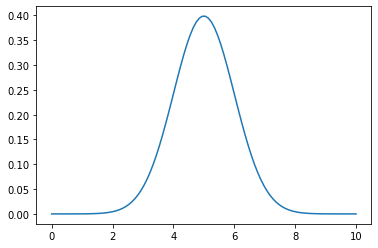

In [465]:
vector_length = 10
rv = norm(loc = vector_length/2, scale = vector_length/10)
x = np.linspace(0, vector_length, 100)
plt.plot(x, rv.pdf(x))

In [103]:
from scipy import ndimage as ndi

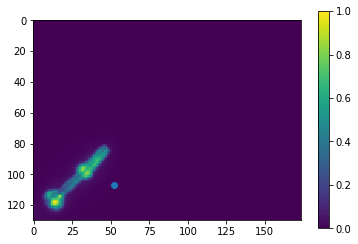

In [123]:
I = ex.raw_image_data.sel(wavelength='410', pair=0).isel(strain=0).data
x, y = ndi.center_of_mass(I - np.uint16(np.median(I)))
plt.imshow(I)
plt.scatter(x, y)
plt.colorbar()

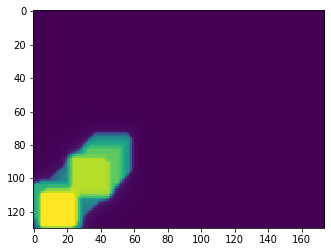

In [132]:
plt.imshow(ndi.percentile_filter(I, 99, 20))

In [133]:
from skimage.feature import shape_index

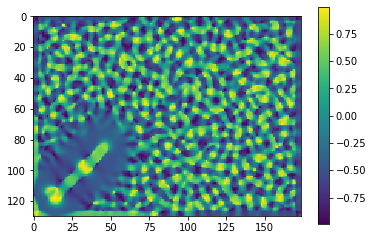

In [138]:
plt.imshow(shape_index(ndi.gaussian_filter(I - np.median(I), sigma=2.0)))
plt.colorbar()

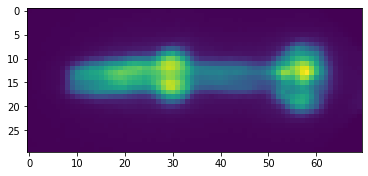

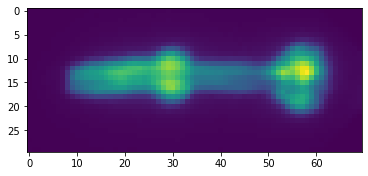

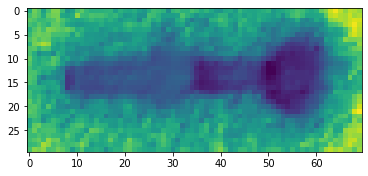

In [166]:
I410 = ex.rot_fl[0,1,0,50:80,50:120].data
I470 = ex.rot_fl[0,2,0,50:80,50:120].data


plt.imshow(I410)
plt.figure()
plt.imshow(I470)
plt.figure()
plt.imshow(I410/I470)

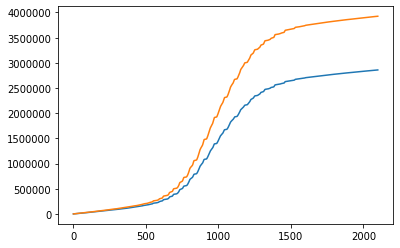

In [173]:
cdf_410 = np.cumsum(I410.ravel())
cdf_470 = np.cumsum(I470.ravel())
plt.plot(cdf_410)
plt.plot(cdf_470)

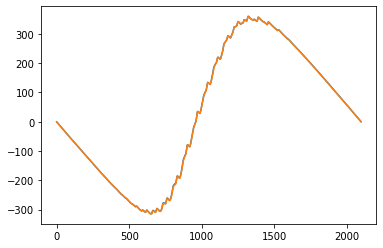

In [177]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

scaled_410 = scaler.fit_transform(I410.ravel().reshape(-1, 1))
scaled_470 = scaler.fit_transform(I470.ravel().reshape(-1, 1))

plt.plot(np.cumsum(scaled_410))
plt.plot(np.cumsum(scaled_470))

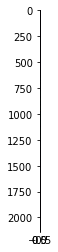

In [182]:
plt.imshow(scaler.fit_transform(I410.ravel().reshape(-1, 1)))

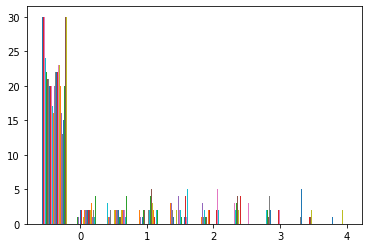

In [183]:
plt.hist(scaler.fit_transform(I410.ravel().reshape(-1, 1)).reshape(I410.shape));

In [184]:
masked = ex.rot_fl * ex.rot_seg

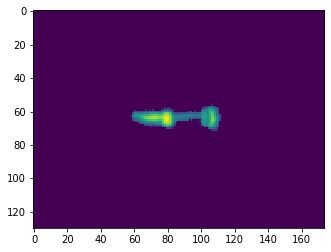

In [193]:
plt.imshow(masked[9,1,0])

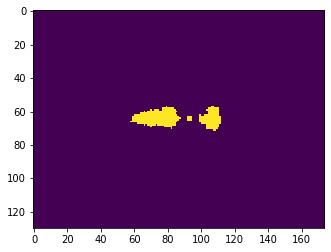

In [190]:
plt.imshow(ex.rot_seg[3,1,0])

In [195]:
ex.trimmed_intensity_data.sel(wavelength='410').mean()

<xarray.DataArray ()>
array(7473.438543)
Coordinates:
    wavelength  <U3 '410'

In [197]:
ex.trimmed_intensity_data.sel(wavelength='470').mean()

<xarray.DataArray ()>
array(5511.627091)
Coordinates:
    wavelength  <U3 '470'

In [198]:
ex.trimmed_intensity_data.sel(wavelength='470').std()

<xarray.DataArray ()>
array(1517.388754)
Coordinates:
    wavelength  <U3 '470'

In [199]:
ex.trimmed_intensity_data.sel(wavelength='410').std()

<xarray.DataArray ()>
array(2407.20026)
Coordinates:
    wavelength  <U3 '410'

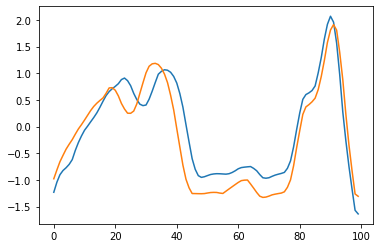

In [204]:
std_410 = (ex.trimmed_intensity_data.sel(wavelength='410', pair=0).isel(strain=1) - ex.trimmed_intensity_data.sel(wavelength='410').mean()) / ex.trimmed_intensity_data.sel(wavelength='410').std()
std_470 = (ex.trimmed_intensity_data.sel(wavelength='470', pair=0).isel(strain=1) - ex.trimmed_intensity_data.sel(wavelength='470').mean()) / ex.trimmed_intensity_data.sel(wavelength='470').std()
plt.plot(std_410)
plt.plot(std_470)

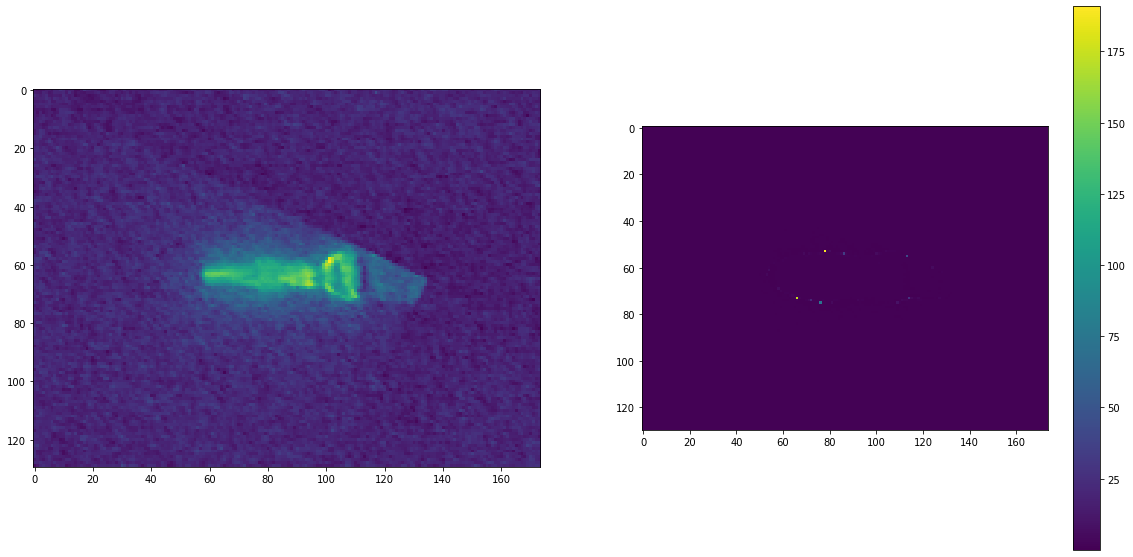

In [242]:
i = 17
i410 = ex.rot_fl.sel(wavelength='410', pair=0).isel(strain=i)
i470 = ex.rot_fl.sel(wavelength='470', pair=0).isel(strain=i)
std_410 = (ex.rot_fl.sel(wavelength='410', pair=0).isel(strain=i) - ex.rot_fl.sel(wavelength='410').mean()) / ex.trimmed_intensity_data.sel(wavelength='410').std()
std_470 = (ex.rot_fl.sel(wavelength='470', pair=0).isel(strain=i) - ex.rot_fl.sel(wavelength='470').mean()) / ex.trimmed_intensity_data.sel(wavelength='470').std()

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))
ax0.imshow(i410 / i470)
plt.imshow(np.abs(std_410 / std_470))
plt.colorbar()

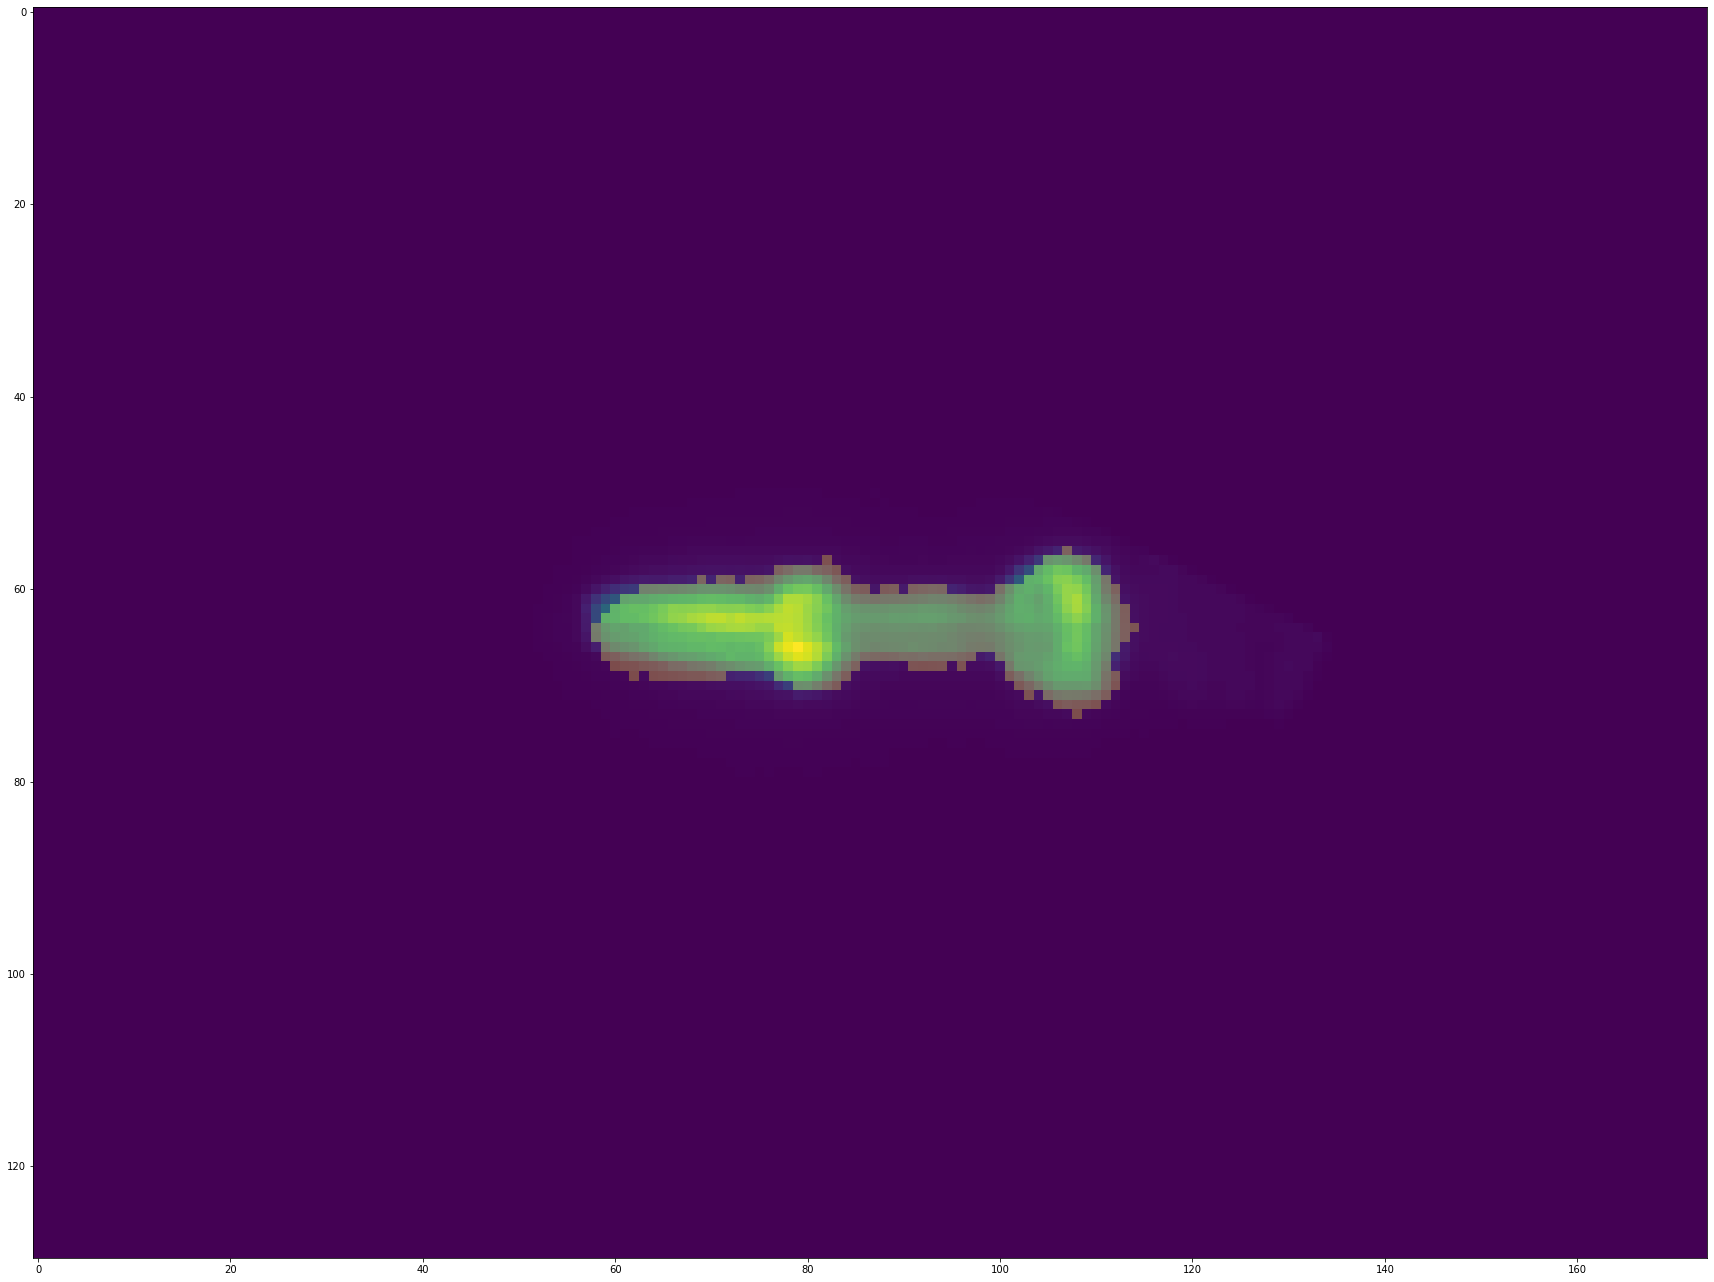

In [247]:
fig, ax = plt.subplots(figsize=(30,30))
plt.imshow(i410)
plt.imshow(ex.rot_seg.sel(wavelength='410', pair=0).isel(strain=0), alpha=0.3)

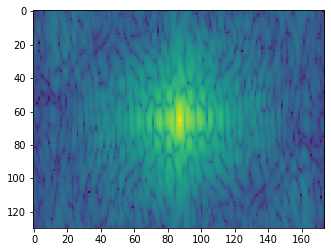

In [259]:
from skimage.transform import frt2

plt.imshow(i410)
FS = np.fft.fft2(i410.data)
plt.imshow(np.log(np.abs(np.fft.fftshift(FS))**2))

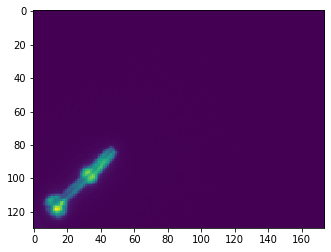

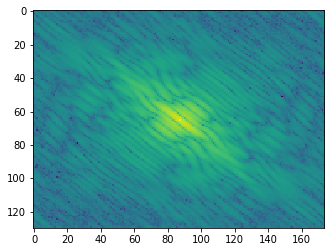

In [261]:
from skimage.transform import frt2

i410 = ex.raw_image_data.sel(wavelength='410', pair=0).isel(strain=0)
plt.imshow(i410)
FS = np.fft.fft2(i410.data)
plt.figure()
plt.imshow(np.log(np.abs(np.fft.fftshift(FS))**2))

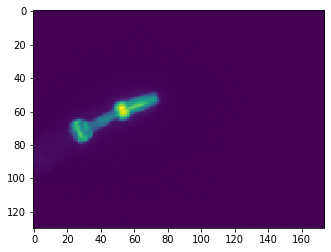

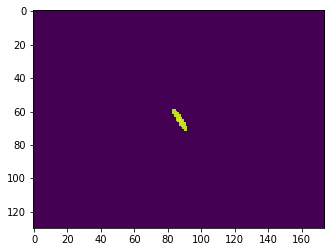

In [353]:
from skimage.transform import frt2

i410 = ex.raw_image_data.sel(wavelength='470', pair=0).isel(strain=40)
plt.imshow(i410)
FS = np.fft.fft2(i410.data)
scaled_fs = np.log(np.abs(np.fft.fftshift(FS)))
scaled_fs[scaled_fs<14] = 0
plt.figure()
plt.imshow(scaled_fs);

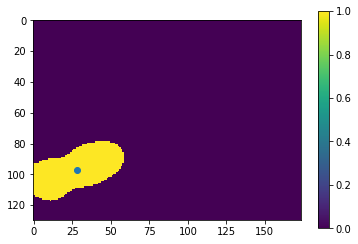

In [321]:
i = 7
GI = ndi.gaussian_filter(ex.raw_image_data.sel(wavelength='410', pair=0).isel(strain=i), sigma=6)
GI_seg = GI.copy()
t = 1000
GI_seg[GI_seg < t] = 0
GI_seg[GI_seg >= t] = 1
plt.imshow(GI_seg)
plt.colorbar()
y, x = measure.regionprops(measure.label(GI_seg))[0].centroid
plt.scatter(x, y)

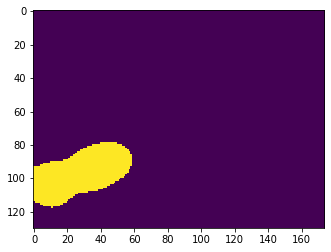

In [336]:
raw_copy = ex.raw_image_data.copy()
raw_copy.data = ndi.gaussian_filter(raw_copy.data, sigma=(0,0,0,6,6))
raw_copy.data[raw_copy.data < t] = 0
raw_copy.data[raw_copy.data > t] = 1
plt.imshow(raw_copy.sel(wavelength='410', pair=0).isel(strain=i))

In [355]:
df = ex.raw_intensity_data.to_pandas()
df

ValueError: cannot convert arrays with 4 dimensions into pandas objects